# Design Document

1. Compute SV of the maximum lottery gain at each probability level given Ss alpha and beta
- sv = probability * value^alpha
- Divide Max SV by 2 to get the halfway SV value (sv_half reference point)
2. Calculate lottery value and safe value needed to match equivalent of SV halfway reference point (money space)
3. Select evenly distributed values along SV halfway and Max SV (reverse for SV Min)
- Compute range between SV Max and SV Halfway, repeat for SV Min and SV Halfway
- Sample within four equal quadrants, defined by number of steps
- Round up $0.50
4. Because beta constrains probability value, trials may not meet desired number (72 per domain)
- Create and add more trials to meet desired number
- Heavy-tailed normalish distribution
5. According to Santiago's notes, Silvia wanted:
- 1 trial at SV_max for both sides ($50, -$50)
- 3 near the middle
- 

1. Get 

In [1]:
%%HTML
<script>
//#NOT FOR PSYCHOPY/PAVLOVIA
current_cell = undefined;
function print(...value){
    //# get the currently running cell:
    var outers = document.getElementsByClassName("cell code_cell rendered running")[0];
    //# the area into which text will be printed:
    var print_space = outers.getElementsByClassName("output_subarea output_html rendered_html")[0];
    //# make the current cell empty the first time you print to it.
    if (!current_cell || current_cell != print_space){
        current_cell = print_space;
        print_space.innerHTML = "";
    }
    //# add the text to a new line with div:
    print_space.innerHTML += ("<div>"+value+"</div>").replaceAll(", ", ",").replaceAll(",", ", ").replaceAll("\n", "</div><div>");
    //print_space.innerHTML = "";
    
    
}
print("Hello Jupyter Cell");
</script>

In [2]:
%%HTML
<script>

//#NOT FOR PSYCHOPY/PAVLOVIA
function print_dict_arr(d) {
    //# get the currently running cell:
    var outers = document.getElementsByClassName("cell code_cell rendered running")[0];
    //# the area into which text will be printed:
    var print_space = outers.getElementsByClassName("output_subarea output_html rendered_html")[0];
    //# make the current cell empty the first time you print to it.
    if (!current_cell || current_cell != print_space){
        current_cell = print_space;
        print_space.innerHTML = "";
    }
    keys = Object.keys(d);
    print(keys);
        
    key = keys[0];
    rows = d[key].length;
    range(rows).forEach(function(i){
        print_space.innerHTML += "<div>"
        keys.forEach(function(key, k) {
            //# add the text to a new line with div:
            print_space.innerHTML += d[key][i];
            if (k<keys.length-1){
                print_space.innerHTML += ",";
            }
        });
        print_space.innerHTML += "<div>";
        print_space.innerHTML = print_space.innerHTML.replaceAll(", ", ",").replaceAll(",", ", ").replaceAll("\n", "</div><div>");
    });
    
    
    
}
d = {"a":[1,2,3,4], "b":[5,6,7,8]}
print_dict_arr(d);
</script>

In [3]:
%%HTML
<script>
//###INCLUDE IN PSYCHOPY EXP###

//# because Pavlovia doesn't auto-convert append or extend to push, 
//#  make the same functions work for any javascript array by affecting the prototype
Array.prototype.append = Array.prototype.push
Array.prototype.extend = function(arr){this.push(...arr)};

//# avoid using the "function name(){}" syntax
//#  to account for Pavlovia's scope problems.

range = function(start_stop, post_stop, step=1){
    //# create a list sequence with a starting point, stopping point, and step size
    //#  the step size is assumed 1 if not provided
    //#  the first value is considered the stopping point if the second value is not given,
    //#   in which case the starting point is assumed to be 0.
    //#  post_stop is the non-inclusive end point.
    var arr = [];
    if (post_stop != undefined){
        for (var i = start_stop; i < post_stop; i+=step){
            arr.push(i);
        }
    } else {
        for (var i = 0; i < start_stop; i+=step){
            arr.push(i);
        }
    }
    return arr;
}

round = function(value, decimals){
    //# JavaScript's Math.round() doesn't normally
    //#  allow you to specify how many decimals you want!
    var tmp = Math.pow(10, decimals);
    return Math.round(value*tmp)/tmp;
}

arange = function(start_stop, post_stop, step=1, rounding=2){
    //# same as range(), but with rounding built-in
    //# create a list sequence with a starting point, stopping point, and step size
    //#  the step size is assumed 1 if not provided
    //#  the first value is considered the stopping point if the second value is not given,
    //#   in which case the starting point is assumed to be 0.
    //#  post_stop is the non-inclusive end point.
    var arr = [];
    if (post_stop != undefined){
        if (post_stop < start_stop){
            for (var i = start_stop; i > post_stop; i+=step){
                arr.push(round(i,rounding))
            } 
        } else {
            for (var i = start_stop; i < post_stop; i+=step){
                arr.push(round(i,rounding))
            } 
        }
    } else {
        if (start_stop < 0){
            for (var i = 0; i > start_stop; i+=step){
                arr.push(round(i,rounding))
            }
        } else {
            for (var i = 0; i < start_stop; i+=step){
                arr.push(round(i,rounding))
            }
        }
    }
    return arr;
}

clone = function(arr){
    //# recursive function to deep copy arrays and dictionaries    
    var loops, tmp;
    //# see if it is an array
    //#  check a couple of things to try to avoid objects with these keys
    if (Array.isArray(arr)){
        loops = arr;
        tmp = [];
    } else {
        loops = Object.keys(arr);
        tmp = {};
    }
    loops.forEach(function(val){
        var value;
        //# if the looped items are the array, push() to a list
        if (loops === arr){
            value = val;
            if (typeof(value) == "object"){
                //# if the subelement is another complex object, 
                //#  then clone it as well.
                tmp.push(clone(value));
            } else {
                tmp.push(value);
            }
        } else { //# if the looped items are the dictionary
                 //#  add them with the key
            value = arr[val];
            if (typeof(value) == "object"){
                //# if the subelement is another complex object, 
                //#  then clone it as well.
                tmp[val] = clone(value);
            } else {
                tmp[val] = value;
            }
        }
    })
    return tmp;
}

sum = function(arr){return arr.reduce((partialSum, a) => partialSum + a, 0)}
</script>

In [4]:
%%HTML
<script>
//###INCLUDE IN PSYCHOPY EXP###

//# contains useful random number generation functions.
random = {"random": function(start_stop=1, post_stop=undefined, count=1){
                var results = [];
                range(count).forEach(function(){
                  //# Math.random() never gives exactly 1, so it
                  //#  never reaches the provided max value.
                  if (post_stop != undefined){
                      if (post_stop < start_stop){
                          var tmp = post_stop;
                          post_stop = start_stop;
                          start_stop = tmp;
                      }
                      results.push((start_stop+Math.random()*(post_stop-start_stop)));
                  } else {
                      //# if post_stop is not defined, start_stop is the non-inclusive max value.
                      results.push((Math.random()*start_stop));
                  }
                });
                if (count == 1)
                    return results[0];
                return results;       
          }, 
          "randint":function(start_stop, post_stop, count=1){
                var results = [];
                range(count).forEach(function(){
                  //# Math.random() never gives exactly 1, so it
                  //#  never reaches the provided max value.
                  if (post_stop != undefined){
                      if (post_stop < start_stop){
                          var tmp = post_stop;
                          post_stop = start_stop;
                          start_stop = tmp;
                      }
                      results.push(parseInt(start_stop+Math.random()*(post_stop-start_stop)));
                  } else {
                      //# if post_stop is not defined, start_stop is the non-inclusive max value.
                      results.push(parseInt(Math.random()*start_stop));
                  }
                });
                if (count == 1)
                    return results[0];
                return results;
          },
          "choice":function(arr, count=1, with_replacement=true){
                var results = [];
                if (with_replacement){
                    range(count).forEach(function(){
                        results.push(arr[random.randint(arr.length)]);
                    });
                } else {
                    //# make a shallow copy to choose from.
                    //#  you can always clone the returned result if you want unique copies,
                    //#  and it makes no difference for arrays of primitives 
                    //#  (like numeric indices or string keys).
                    var tmp = [...arr];//#clone(arr);
                    console.log(tmp);
                    range(count).forEach(function(){
                        if (tmp.length == 0)
                            //# refill the array
                            tmp = [...arr]; //#clone(arr);
                        results.push(tmp.splice(random.randint(tmp.length), 1));
                    });
                }
                if (count == 1)
                    return results[0];
                return results;
          }}
</script>

In [15]:
%%HTML
<script>
//###INCLUDE IN PSYCHOPY EXP###

//#Global variables
alpha_gain = 0.6;
alpha_loss = 1.28;
beta_gain = 1.28;
beta_loss = 1.28;
prob = 0.5;
amb = 0; 
steps = 4;
//#domain: gain = 1, loss = -1


append_trial = function(trials, safe_sv, lott_sv, lott, safe, prob, amb, sv_half, domain){
    //#appends trial info for presentation and output
    trials["crdm_safe_sv"].append(safe_sv);
    trials["crdm_lott_sv"].append(safe_sv);
    trials["crdm_lott"].append(lott);
    trials["crdm_sure_amt"].append(safe);
    trials["crdm_lott_p"].append(prob);
    trials["crdm_amb_lev"].append(amb);
    trials["crdm_delta_sv"].append(lott_sv-safe_sv);
    trials["crdm_domain"].append(domain);
}

lottery2sv = function(objective_value, alpha_risk_aversion, beta_ambiguity_aversion, probability, ambiguity){
    //#converts lottery option value from money space --> subjective value space
    //#domain considered where function is called
    return Math.sign(objective_value)*(probability-beta_ambiguity_aversion
                    *(ambiguity/2))*Math.pow(Math.abs(objective_value), alpha_risk_aversion);
}

round2fiddy = function(number){
    //#rounding all money values to nearest $0.50
    return Math.round(number*2)/2;
}

safe2sv = function(subjective_value, alpha){ //#deprecated
    //#converts safe option value from money space --> subjective value space
    return Math.sign(subjective_value)*Math.pow(Math.abs(subjective_value), alpha);
}

sort_it = function(arr){
    //#sort ascending (used for SVs)
    arr.sort(function(a,b){return a-b});
}

sv2money = function(subjective_value, domain, alpha, beta, prob, amb){ 
    //#based on whether you provide beta, converts each value in the 
    //# subjective value (safe & lottery) range --> money spaces
    var money;
    if (beta === undefined){ //#beta isn't used for safe money
        //#compute safe money using inverse of SV formula
        //# gain - money(V) = 1*SV**1/alpha
        //# loss - money(V) = -1*SV**1/alpha
        money = round2fiddy(domain*Math.pow(Math.abs(subjective_value), 1/alpha)); 
    } else {
        //#compute lottery money using inverse of SV formula
        //# gain - money(V) = 1*(SV/P-B*A/2)**1/alpha
        //# loss - money(V) = -1*(SV/P-B*A/2)**1/alpha
        money = round2fiddy(domain*Math.pow(Math.abs(subjective_value)/(prob-beta*amb/2), 1/alpha));
    }
    //#constrains min and max lottery $ and ensure correct sign for gain/loss
    money = domain * Math.min(50, Math.max(0.5, Math.abs(money)));
    return money
}

make_sample_sv_ranges = function(domain, alpha, beta, prob, amb, steps){
    //#calculates SVdeltas and corresponding monetary values
    var sv_max = domain*lottery2sv(50, alpha, beta, prob, amb); //#maximum possible lottery value ($ --> SV space)
    var sv_min = 0; //#domain*safe2sv(0.5, alpha); //#minimum possible lottery value ($ --> SV space)
    var sv_half = sv_max/2; //#SV of trial halfway between 0 and max lottery gain (true center)
    var step_size = (sv_max-sv_min)/(2*steps-1);
    var space = arange(sv_min, sv_max+step_size/2, step_size);
    return [space, sv_half];
}


crdm_trials_dict = {"crdm_safe_sv":[], "crdm_lott_sv":[], "crdm_lott":[], "crdm_sure_amt":[], //#trial variables
                    "crdm_lott_p":[], "crdm_amb_lev":[], "crdm_delta_sv":[], "crdm_domain":[]};

generate_trials = function(trials, domain, alpha, beta, steps){
    //#creates trial schedule for each domain (gain/loss)
    var amb_space = [0.24, 0.5, 0.74]; //#possible ambiguity values
    var prob_space = [0.13, 0.25, 0.38, 0.5, 0.75]; //#possible probability values
    var trials_per = 9; //#number of trials per unique prob/amb option
    var choice_idxs = [0,1,2,3,3.5,4,5,6,7];
    var delta_idx = range(8); //#index of trials_remaining_per_sv_delta array

    prob_space.forEach(function(prob){
        //#non-ambiguity trials
        var tmp = make_sample_sv_ranges(domain, alpha, beta, prob, 0, steps);
        var svs = tmp[0]; //#get list of SV quadrants
        var sv_half = tmp[1]; //#get SV_half
        range(trials_per).forEach(function(_, tidx){ //#for each of 9 trials per prob
            var choice_idx = choice_idxs[tidx]; //#current sample index
            if (choice_idx != parseInt(choice_idx)){ //#if not an integer
                var inty = parseInt(choice_idx); //#turn it into integer
                choice_idx = random.randint(inty, inty+2); //#randomly sample within two steps
            }
            var subspace_sv = svs[choice_idx]; //#specific random SV for curr quad
            var lott = sv2money(subspace_sv, domain, alpha, beta, prob, 0); //#specific lottery $ for curr quad
            var safe = sv2money(sv_half, domain, alpha); //#specific safe $ for curr quad
            append_trial(trials, sv_half, subspace_sv, lott, safe, prob, 0, sv_half, domain); //#save to trials dict
        });

    });

    amb_space.forEach(function(amb){
        //#ambiguity trials
        var tmp = make_sample_sv_ranges(domain, alpha, beta, 0.5, amb, steps);
        var svs = tmp[0]; //#get list of SV quadrants
        var sv_half = tmp[1]; //#get SV_half
        //#print("losses", svs)
        //#print("losses", sv_half)
        range(trials_per).forEach(function(_, tidx){ //#for each of 9 trials per amb
            var choice_idx = choice_idxs[tidx]; //#current sample index
            if (choice_idx != parseInt(choice_idx)){ //#if not an integer
                var inty = parseInt(choice_idx); //#turn it into integer
                choice_idx = random.randint(inty, inty+2); //#randomly sample within two steps
            }
            var subspace_sv = svs[choice_idx]; //#specific random SV for curr quad
            var lott = sv2money(subspace_sv, domain, alpha, beta, 0.5, amb); //#specific lottery $ for curr quad
            var safe = sv2money(sv_half, domain, alpha); //#specific safe $ for curr quad
            append_trial(trials, sv_half, subspace_sv, lott, safe, 0.5, amb, sv_half, domain); //#save to trials dict
        });

    });
}

//#generate schedule for each domain
generate_trials(crdm_trials_dict, 1, alpha_gain, beta_gain, steps); //#gain trials
generate_trials(crdm_trials_dict, -1, alpha_loss, beta_loss, steps); //#loss trials

window.executePython = function(python) {
    #function to convert trials dictionary from JS to Python for visualization
    return new Promise((resolve, reject) => {
        var callbacks = {
            iopub: {
                output: (data) => resolve(data.content.text.trim())
            }
        };
        Jupyter.notebook.kernel.execute(`${python}`, callbacks);    
    });
}
window.executePython("trials = "+JSON.stringify(trials));


</script>

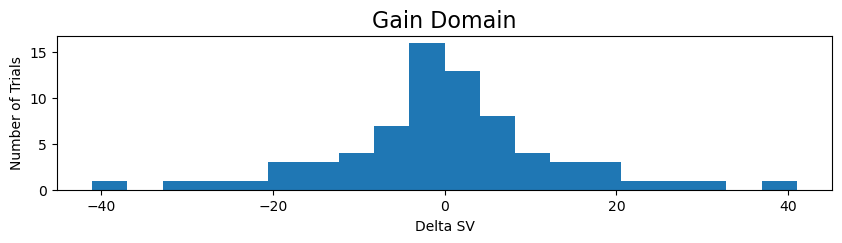

Alpha: 0.6
Beta: 1.28


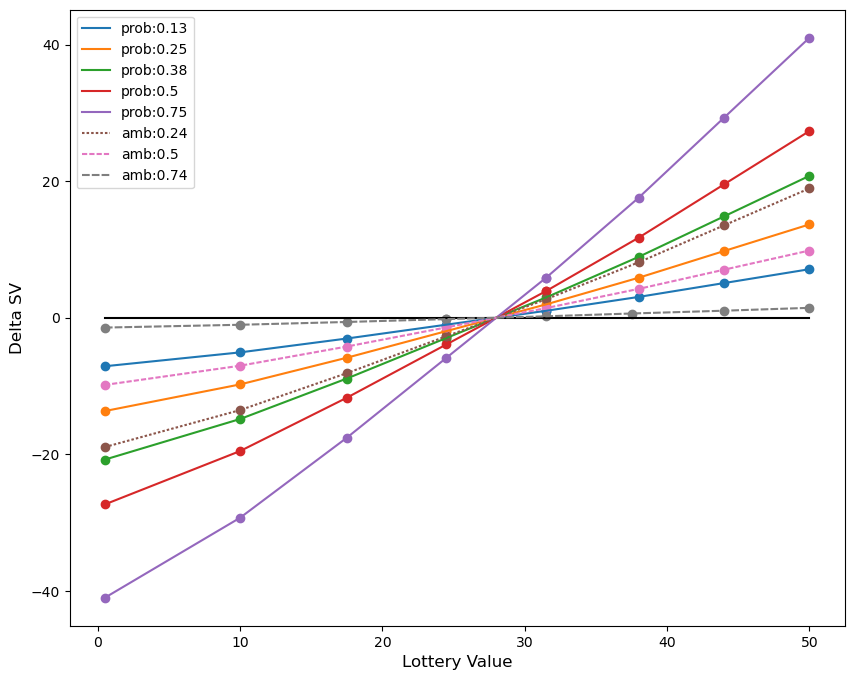

In [16]:
import pandas as pd
import numpy as np
import pylab as plt
df = pd.DataFrame(trials)

bins = 20
plt.figure(figsize=(10,2))
gain = df.query("crdm_domain == 1")["crdm_delta_sv"].values
plt.hist(gain, bins=bins)
plt.ylabel("Number of Trials")
plt.xlabel("Delta SV")
plt.title("Gain Domain", fontsize=16)
plt.show()

print("Alpha: 0.6")
print("Beta: 1.28")
df = pd.DataFrame(trials)
gain = df.query("crdm_domain == 1")
plt.figure(figsize=(10,8))
plt.plot([0.5,50], [0,0], color="black")
prob_trials = gain.query("crdm_amb_lev == 0")
prob = np.unique(prob_trials["crdm_lott_p"].values)

for p in prob:
    trial_set = prob_trials.query("crdm_lott_p == @p")
    money = trial_set["crdm_lott"].values
    idx = np.argsort(money)
    sv = trial_set["crdm_delta_sv"].values
    plt.plot(money[idx], sv[idx], label="prob:"+str(p))
    plt.scatter(money[idx], sv[idx])
amb_trials = gain.query("crdm_amb_lev != 0")
amb = np.unique(amb_trials["crdm_amb_lev"].values)
for a in amb:
    trial_set = amb_trials.query("crdm_amb_lev == @a")
    money = trial_set["crdm_lott"].values
    idx = np.argsort(money)
    sv = trial_set["crdm_delta_sv"].values
    plt.plot(money[idx], sv[idx], label="amb:"+str(a), dashes=[5*a,1])
    plt.scatter(money[idx], sv[idx])
plt.xlabel("Lottery Value", fontsize=12)
plt.ylabel("Delta SV", fontsize=12)
plt.legend()
plt.show()

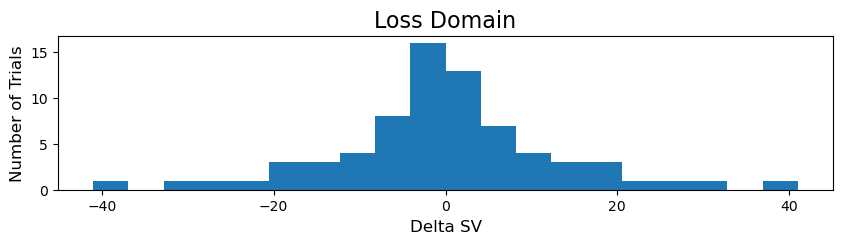

Alpha: 1.2
Beta: 1.28


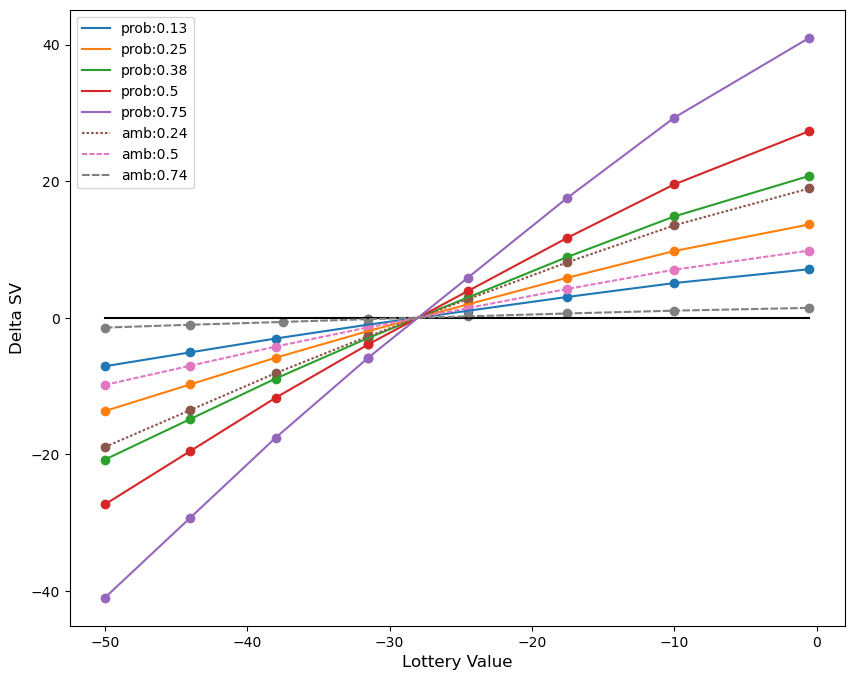

In [7]:
import pandas as pd
import numpy as np
import pylab as plt
df = pd.DataFrame(trials)

#barplot
bins = 20
plt.figure(figsize=(10,2))
loss = df.query("crdm_domain == -1")["crdm_delta_sv"].values
plt.hist(loss, bins=bins)
plt.ylabel("Number of Trials", fontsize=12)
plt.xlabel("Delta SV", fontsize=12)
plt.title("Loss Domain", fontsize=16)
plt.show()

print("Alpha: 1.2")
print("Beta: 1.28")

#histogram
df = pd.DataFrame(trials)
loss = df.query("crdm_domain == -1")
plt.figure(figsize=(10,8))
plt.plot([-0.5,-50], [0,0], color="black")
prob_trials = loss.query("crdm_amb_lev == 0")
prob = np.unique(prob_trials["crdm_lott_p"].values)

for p in prob:
    trial_set = prob_trials.query("crdm_lott_p == @p")
    money = trial_set["crdm_lott"].values
    idx = np.argsort(money)
    sv = trial_set["crdm_delta_sv"].values
    plt.plot(money[idx], sv[idx], label="prob:"+str(p))
    plt.scatter(money[idx], sv[idx])
amb_trials = loss.query("crdm_amb_lev != 0")
amb = np.unique(amb_trials["crdm_amb_lev"].values)
for a in amb:
    trial_set = amb_trials.query("crdm_amb_lev == @a")
    money = trial_set["crdm_lott"].values
    idx = np.argsort(money)
    sv = trial_set["crdm_delta_sv"].values
    plt.plot(money[idx], sv[idx], label="amb:"+str(a), dashes=[5*a,1])
    plt.scatter(money[idx], sv[idx])
plt.xlabel("Lottery Value", fontsize=12)
plt.ylabel("Delta SV", fontsize=12)
plt.legend()
plt.show()

In [8]:
%%HTML
<script>
var alphas = arange(0.01,1.,.025,2);
var space, sv_half;
var svs = [];
var moneys = [];
var domain = 1;
var beta = 0;
var amb = 0;
var prob = .5;

var lot_svs_lines = [];
var lot_money_lines = [];
var lot_svs_lines_recomp = [];
range(8).forEach(function(_){
    lot_svs_lines.append([]);
    lot_money_lines.append([]);
    lot_svs_lines_recomp.append([]);
})
var safe_svs_line = [];
var safe_money_line = [];
var safe_svs_line_recomp = [];

alphas.forEach(function(alpha){
    [space, sv_half] = make_sample_sv_ranges(1, alpha, beta, prob, amb, 4);
    var safe = sv_to_money(sv_half, domain, alpha);
    safe_svs_line.append(sv_half);
    safe_money_line.append(safe);
    var safe_sv = safe_to_sv(safe, alpha);
    safe_svs_line_recomp.append(safe_sv);
    space.forEach(function(lott_sv, i){
        var lott = sv_to_money(lott_sv, domain, alpha, beta, prob, amb);    
        lot_svs_lines[i].append(lott_sv);
        lot_money_lines[i].append(lott);
        var lot_sv = lottery_to_sv(lott, alpha, beta, prob, amb)
        lot_svs_lines_recomp[i].append(lot_sv);
    })
    
    
});
//# the last space is just used to say how many there are
//#  (it changes every time)
window.executePython("space = "+JSON.stringify(space));
window.executePython("alphas = "+JSON.stringify(alphas));
window.executePython("lot_svs_lines = "+JSON.stringify(lot_svs_lines));
window.executePython("lot_svs_lines_recomp = "+JSON.stringify(lot_svs_lines_recomp));
window.executePython("safe_svs_line = "+JSON.stringify(safe_svs_line));
window.executePython("safe_svs_line_recomp = "+JSON.stringify(safe_svs_line_recomp));
window.executePython("lot_money_lines = "+JSON.stringify(lot_money_lines));
window.executePython("safe_money_line = "+JSON.stringify(safe_money_line));
</script>

In [9]:
from matplotlib import pyplot as plt
import numpy as np
# SVs

plt.figure(figsize=(9,9))
for i, s in enumerate(space):
    idx = i-4
    if idx==0:
        plt.plot(alphas, np.array(safe_svs_line)-np.array(safe_svs_line), dashes=[4,4], label="ΔSV-idx:"+str(idx))
        idx+=1
    elif idx > 0:
        idx+=1
    plt.plot(alphas, np.array(lot_svs_lines)[i]-np.array(safe_svs_line), label="ΔSV-idx:"+str(idx))
plt.rcParams.update({'font.size': 12})
plt.legend()
plt.xlabel("α")
plt.ylabel("ΔSV")
plt.rcParams.update({'font.size': 16})
plt.title("Fig 1. Change in ΔSVs from SV($50 | α=x, β=0, p=0.5, A=0)÷2 along α")
plt.tight_layout()
plt.savefig("fig1.jpg", bbox_inches='tight')
plt.show()
print("Figure 1 above demonstrates that as the value of alpha decreases, DeltaSV space becomes more compressed. \n")


# money
plt.figure(figsize=(9,9))
for i, s in enumerate(space):
    idx = i-4
    if idx==0:
        plt.plot(alphas, np.array(safe_money_line), dashes=[4,4], label="$safe@ΔSV-idx:"+str(idx))
        idx+=1
    elif idx > 0:
        idx+=1
    plt.plot(alphas, np.array(lot_money_lines)[i], label="$lott@ΔSV-idx:"+str(idx))

plt.rcParams.update({'font.size': 12})
plt.xlabel("α")
plt.ylabel("$ Value")
money = np.arange(0., 50.5, 5)
money[0] = .5
plt.gca().yaxis.set_major_formatter('${x:1.2f}')
plt.yticks(money)
plt.legend(loc = 'upper left')
plt.rcParams.update({'font.size': 16})
plt.title("Fig 2. Change in monetary values per ΔSV along α")
plt.tight_layout()
plt.savefig("fig2.jpg", bbox_inches='tight')
plt.show()
print("""Figure 2 illustrates that (1) as alpha decreases, more DeltaSV values will produce $0.50 for both safe \n 
and lottery options. This is because -with low alpha- the SV_half is so low that any change within this compressed \n 
DeltaSV space will be rounded up to $0.50 when translated into money space (w/ exception of SV_Max). \n
As alpha increases past ~0.6, differences in safe and lottery money values become discernible. \n
(2) However, even when alpha exceeds 0.6 and beyond, DeltaSV indices -3 and -4 will always produce money values \n
for lottery jackpot that are lower than the safe option (beta = 0, ambiguity = 0). \n""")


# recomputed SVs
plt.figure(figsize=(12,12))
for i, s in enumerate(space):
    idx = i-4
    if idx==0:
        plt.plot(alphas, np.array(safe_svs_line_recomp)-np.array(safe_svs_line_recomp), dashes=[4,4], label="ΔSV-idx:"+str(idx))
        idx+=1
    elif idx > 0:
        idx+=1
    plt.plot(alphas, np.array(lot_svs_lines_recomp)[i]-np.array(safe_svs_line_recomp), label="ΔSV-idx:"+str(idx))

#plt.rcParams.update({'font.size': 14})
plt.legend()

plt.xlabel("α")
plt.ylabel("ΔSV")
plt.rcParams.update({'font.size': 16})
plt.title("Fig 3. Recomputed from \$ change in ΔSVs from SV($50 | α=x, β=0, p=0.5, A=0)÷2 along α")
plt.tight_layout()
plt.savefig("fig3.jpg", bbox_inches='tight')
plt.show()
print("""Figure 3 shows that rounding the monetary values to $0.50, while necessary, leads to exacerbated \n
problems with low alpha. The true SVs are based on the money values we present per trial. When we recompute \n
the DeltaSV from rounded monetary values, unusual things happen. Because of the difference in probability \n
value when computing SV for lottery money value compared to safe money value, at low alpha, the lottery \n
SV -even for SV_Max- will be lower than the safe SV after monetary rounding. \n
*** Figures 1-3 TLDR *** \n
*Low alpha --> SV range compression (_alpha's fault_)\n
*Rounding to $0.50 --> money range compression (_rounding's fault_) \n
*Calculating true SV for rounded money --> insanely inflates safe SV relative to initial compressed SV scale \n
such that true safe SV (p=1) exceeds SV_Max (p=0.5) (_probability's fault_) \n
*Adding beta and ambiguity to the formula as non-zero values magnifies previous issues to new extremes""")

NameError: name 'space' is not defined

<Figure size 900x900 with 0 Axes>